In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline
plt.style.use('ggplot')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error


In [103]:
def plot_results(results_list,n_trees, xlims, ylims,gberrors = [], relative = True):
    """Plots the results from results_list in 3 different columns if ylims are the same it uses auto y limits"""
    fig, axs = plt.subplots(ncols=len(results_list), nrows = 4, figsize = (10*len(results_list),30))
    
    #plots the difference in error between each forest as you add trees from 1 to n_trees and the full n_trees tree model
    #both randomly and in order of oob score
    
    #this loops over sets of results to compare across hyperparameters
    for i,results in enumerate(results_list):
        #loops across models with different train test splits
        totals = []
        for total, scores, random_scores in results:
            totals.append(total)
            if not relative:
                total = 0
            axs[0][i].plot([x for x in range(1,n_trees+ 1)], [s - total  for s in scores], 'b', alpha = 0.1)
            axs[1][i].plot([x for x in range(1,n_trees+ 1)], [s - total  for s in random_scores], 'r', alpha = 0.1)
            axs[2][i].plot([x for x in range(1,n_trees+1)], [s-r for s,r in zip(scores,random_scores)],'m',alpha = 0.1)
            
            if relative: 
                axs[0][i].hlines(0,0,1000,color = 'g',alpha = .8)
                axs[1][i].hlines(0,0,1000,color = 'g',alpha = .8)
                axs[2][i].hlines(0,0,1000,color = 'g',alpha = .8)
        print("mean total error column {}: {}".format(i,np.mean(totals)))

    #plots the average difference between the forests with x trees and the full 1000 tree model
        average_ordered, average_random, average_diff = [],[],[]   
        for x in range(0,n_trees):
            ordered,rand,diff = [],[],[]
            for total,o_scores,r_scores in results:
                if not relative: 
                    total = 0
                ordered.append(o_scores[x] - total)
                rand.append(r_scores[x] - total)
                diff.append(o_scores[x] - r_scores[x])
            average_diff.append(np.mean(diff))
            average_ordered.append(np.mean(ordered))
            average_random.append(np.mean(rand))
        axs[0][i].plot([x for x in range(1,n_trees+ 1)],average_ordered,'b',alpha = .8)        
        axs[1][i].plot([x for x in range(1,n_trees+ 1)],average_random, 'r', alpha = 0.8)
        axs[2][i].plot([x for x in range(1,n_trees+ 1)],average_diff, 'm', alpha = 0.8)
        
        axs[3][i].plot([x for x in range(1,n_trees+ 1)],average_ordered,'b',alpha = .8)                
        axs[3][i].plot([x for x in range(1,n_trees+ 1)],average_random, 'r', alpha = 0.8)
        total_average = 0
        if not relative: 
            total_average = np.mean([r[0] for r in results])
            ylims = ylims[0]+total_average, ylims[1]+total_average
        axs[3][i].hlines(total_average,0,n_trees,color = 'g',alpha = .8)

        #compares to some gradient boosted models (or any errors) if provided
        if gberrors:
            total_average = np.mean([r[0] for r in results])
            if not relative: total_average = 0
            for gbe in gberrors:
                axs[2].hlines( gbe - total_average ,0,n_trees,color='m',alpha = .3)
            axs[2].hlines(np.mean(gberrors),0,n_trees,color='m',alpha = .8)
        #sets the axis limits
        if ylims[0] != ylims[1]:
            axs[0][i].set_ylim(ylims[0],ylims[1])
            axs[1][i].set_ylim(ylims[0],ylims[1])    
            axs[3][i].set_ylim(ylims[0],ylims[1])   
    
        axs[0][i].set_xlim(xlims[0],xlims[1])
        axs[1][i].set_xlim(xlims[0],xlims[1])
        axs[2][i].set_xlim(xlims[0],xlims[1])
        axs[3][i].set_xlim(xlims[0],xlims[1])
    return axs

def plot_average_results(results_list,n_trees, xlims,ylims,titles):
    fig, axs = plt.subplots(ncols=len(results_list), nrows = 1, figsize = (10*len(results_list),10))
    for i,results in enumerate(results_list):   
        average_ordered, average_random, average_diff = [],[],[]   
        for x in range(0,n_trees):
            ordered,rand,diff = [],[],[]
            for total,o_scores,r_scores in results:
                ordered.append(o_scores[x] - total)
                rand.append(r_scores[x] - total)
                diff.append(o_scores[x] - r_scores[x])
            average_diff.append(np.mean(diff))
            average_ordered.append(np.mean(ordered))
            average_random.append(np.mean(rand))        
        axs[i].plot([x for x in range(1,n_trees+ 1)],average_ordered,'b',alpha = .8)                
        axs[i].plot([x for x in range(1,n_trees+ 1)],average_random, 'r', alpha = 0.8)
        axs[i].hlines(0,0,1000,color = 'g',alpha = .8)
        axs[i].set_title(titles[i])
        axs[i].set_ylim(ylims[0],ylims[1])   
        axs[i].set_xlim(xlims[0],xlims[1])

    return axs

In [2]:
data = pd.read_csv('data/OnlineNewsPopularity.csv')

In [3]:
y = data[' shares'].values
X = data.drop([' shares','url',' timedelta'], axis = 1).values

In [4]:
parameters = {
    'n_estimators':[1000],
    'max_features':['sqrt','log2',None], 'max_depth':[2,3,4,5],
    'min_samples_split':[.1,.5],'min_samples_leaf':[1,2,5],
}

rfr = RandomForestRegressor()
grid_search1 = GridSearchCV(rfr, param_grid=parameters, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1, cv = 10, verbose = 0)
grid_search1.fit(X,y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_sampl

KeyboardInterrupt: 

In [270]:
grid_search1.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 0.1,
 'n_estimators': 1000}

In [ ]:
params = {'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 0.1,
 'n_estimators': 1000}
features = [None, 'sqrt', 'log2']
results = []
for f in features:
    params['max_features'] = f
    results.append(run_experiment(X,y,10,10,params))   

10/100 done in 352.0266046524048 seconds
60/100 done in 2074.340336084366 seconds


In [ ]:
axs1 = plot_results(results,500,(0,500),(-100,200))

In [10]:
data2 = pd.read_csv('data/slump_test.data.csv',index_col='No')

In [11]:
X2,y2 = data2.drop('Compressive Strength (28-day)(Mpa)', axis = 1).values,data2['Compressive Strength (28-day)(Mpa)'].values

In [278]:
parameters = {
    'n_estimators':[1000],
    'max_features':['sqrt','log2',None], 'max_depth':[2,3,4,5],
    'min_samples_split':[.1,.5],'min_samples_leaf':[1,2,5],
}

rfr = RandomForestRegressor()
grid_search2 = GridSearchCV(rfr, param_grid=parameters, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1, cv = 10, verbose = 0)
grid_search2.fit(X2,y2)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.3s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.7s
[

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.6s


[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.8s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.8s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=2, max_features=sqr

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min


[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.4s
[CV] max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=Non

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.5min


[CV]  max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.4s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.6s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.7s
[CV] max_depth=4, max_features=sqr

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.7min


[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.5s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.5s
[CV] max_depth=5, max_features=log

[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  5.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000], 'max_features': ['sqrt', 'log2', None], 'max_depth': [2, 3, 4, 5], 'min_samples_split': [0.1, 0.5], 'min_samples_leaf': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [30]:
#params2 = grid_search2.best_params_
params2 = {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 0.1, 'n_estimators': 1000}


In [31]:
params2a,params2b = params2,params2
params2a['max_features'],params2b['max_features'] = 'sqrt',None
results2  = [run_experiment(X2,y2,10,10,params2b),run_experiment(X2,y2,10,10,params2a)]

10/100 done in 14.392448663711548 seconds
60/100 done in 86.19223928451538 seconds
10/100 done in 14.284542322158813 seconds
60/100 done in 85.44421935081482 seconds


In [116]:
params2 = {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 0.1, 'n_estimators': 1000}
changesa = [('sqrt',2),('sqrt',3),('sqrt',4),('sqrt',5)]
resultsa = []
titlesa = []
for c in changesa:
    params2['max_features'], params2['max_depth'] = c[0],c[1]
    resultsa.append(run_experiment(X2,y2,5,10,params2))
    titlesa.append('max_features: {}, max_depth: {}'.format(c[0],c[1]))
    
changesb = [(None,2),(None,3),(None,4),(None,5)]
resultsb = []
titlesb = []
for c in changesb:
    params2['max_features'], params2['max_depth'] = c[0],c[1]
    resultsb.append(run_experiment(X2,y2,5,10,params2))
    titlesb.append('max_features: {}, max_depth: {}'.format(c[0],c[1]))


10/50 done in 13.312127590179443 seconds
10/50 done in 13.294286251068115 seconds
10/50 done in 13.251705646514893 seconds
10/50 done in 14.461668014526367 seconds
10/50 done in 13.280589580535889 seconds
10/50 done in 13.36978816986084 seconds
10/50 done in 14.24544358253479 seconds
10/50 done in 14.319572448730469 seconds


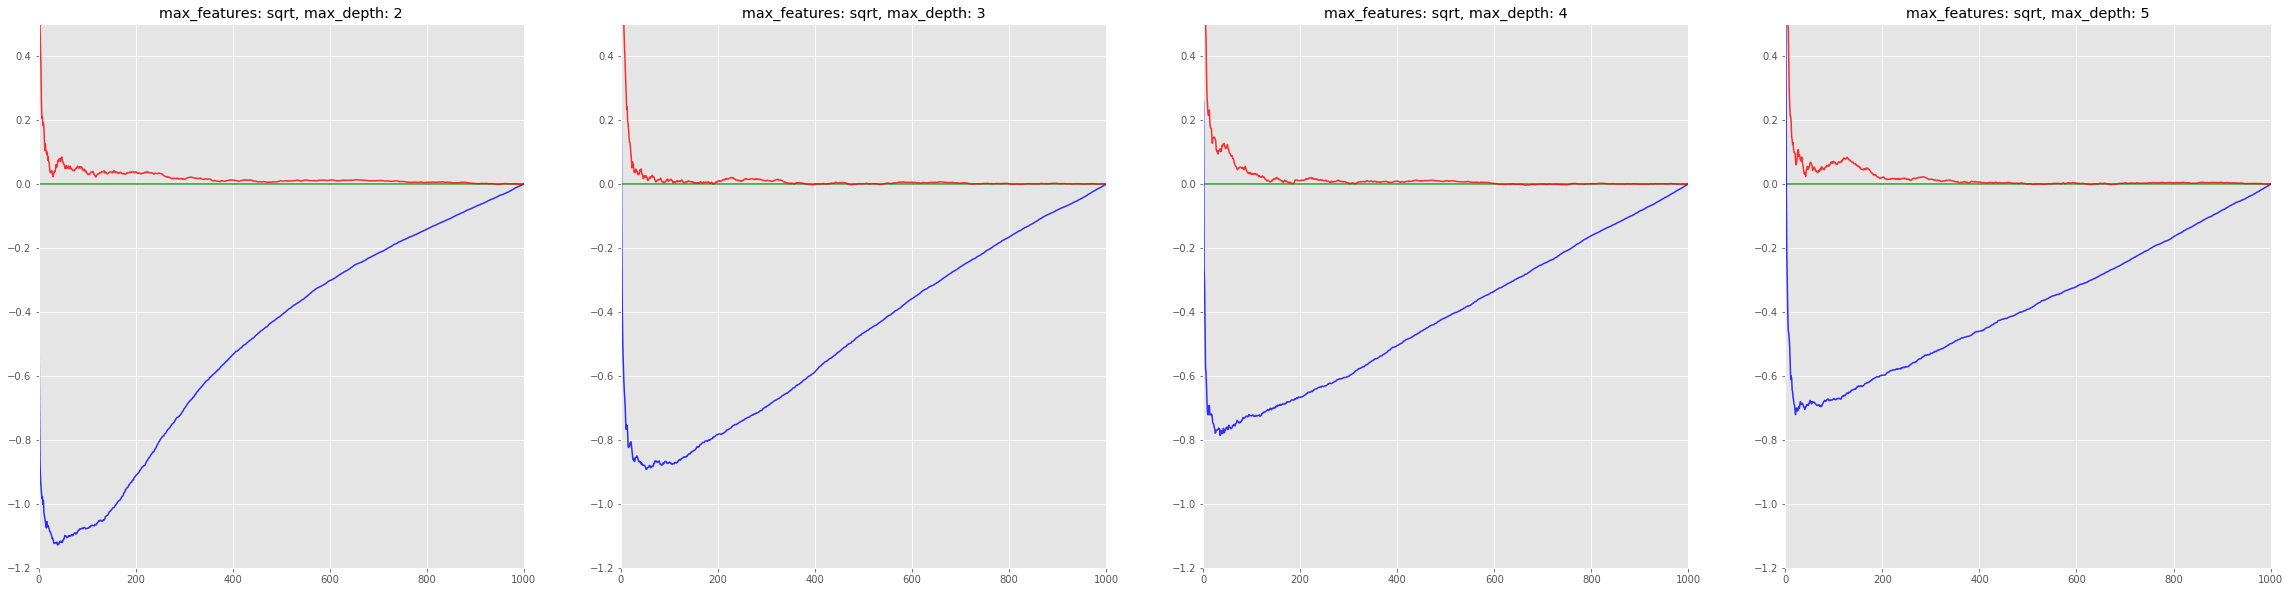

In [123]:
a = plot_average_results(resultsa,1000,(0,1000),(-1.2,.5),titlesa)

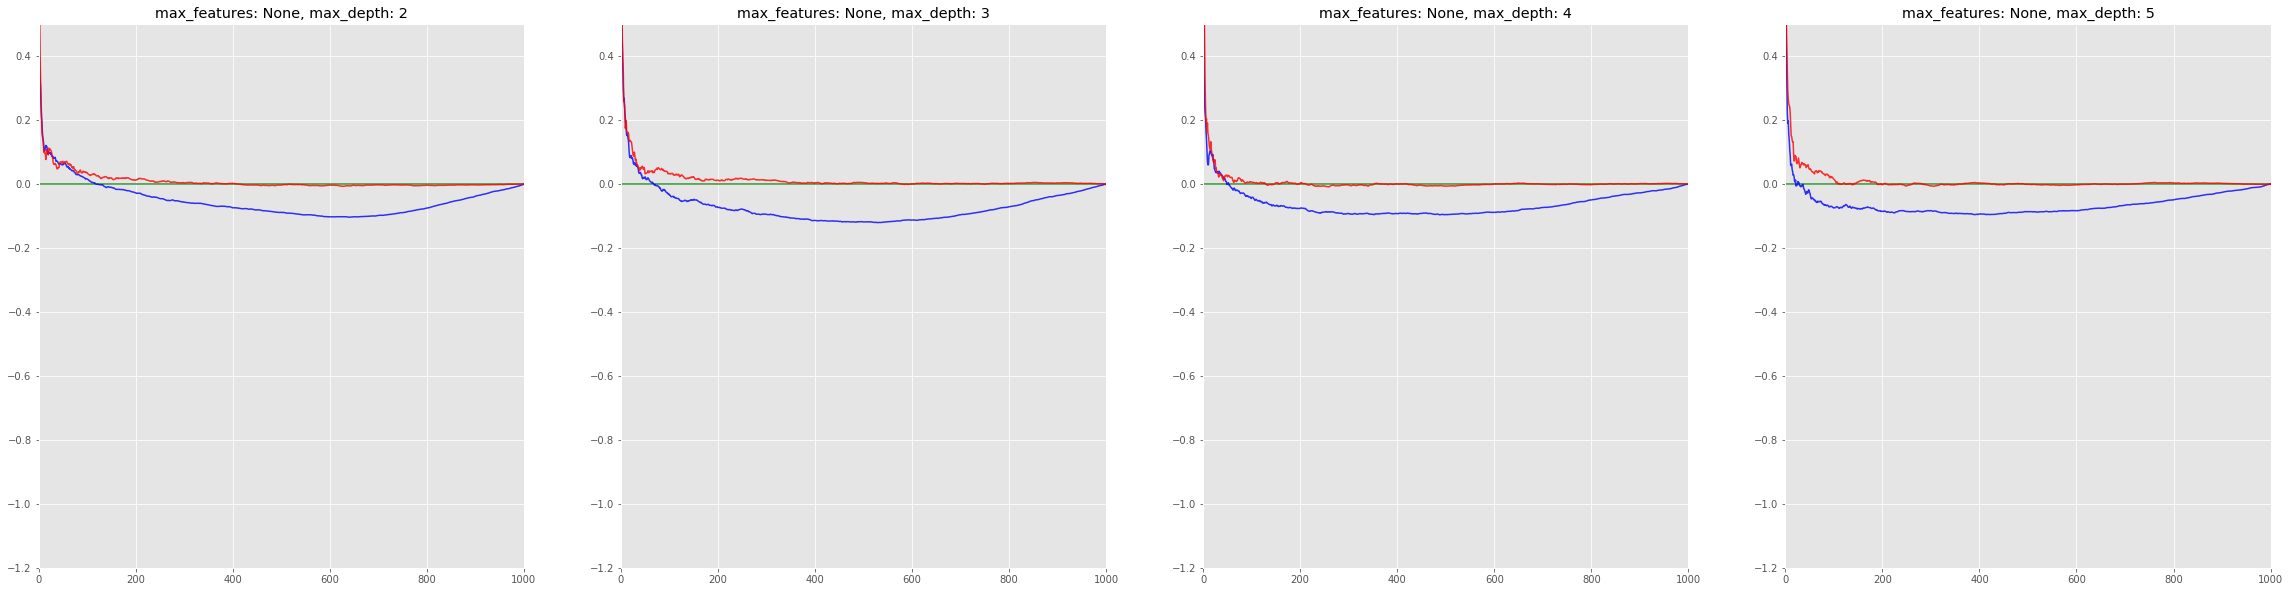

In [124]:
b =  plot_average_results(resultsb,1000,(0,1000),(-1.2,.5),titlesb)

mean total error column 0: 5.60768104942866
mean total error column 1: 4.8398310388685895
mean total error column 2: 4.573685351083734
mean total error column 3: 4.358577932389857
mean total error column 4: 4.371990778618329
mean total error column 5: 3.963941827427133
mean total error column 6: 3.761064040305283
mean total error column 7: 3.6387349056357756


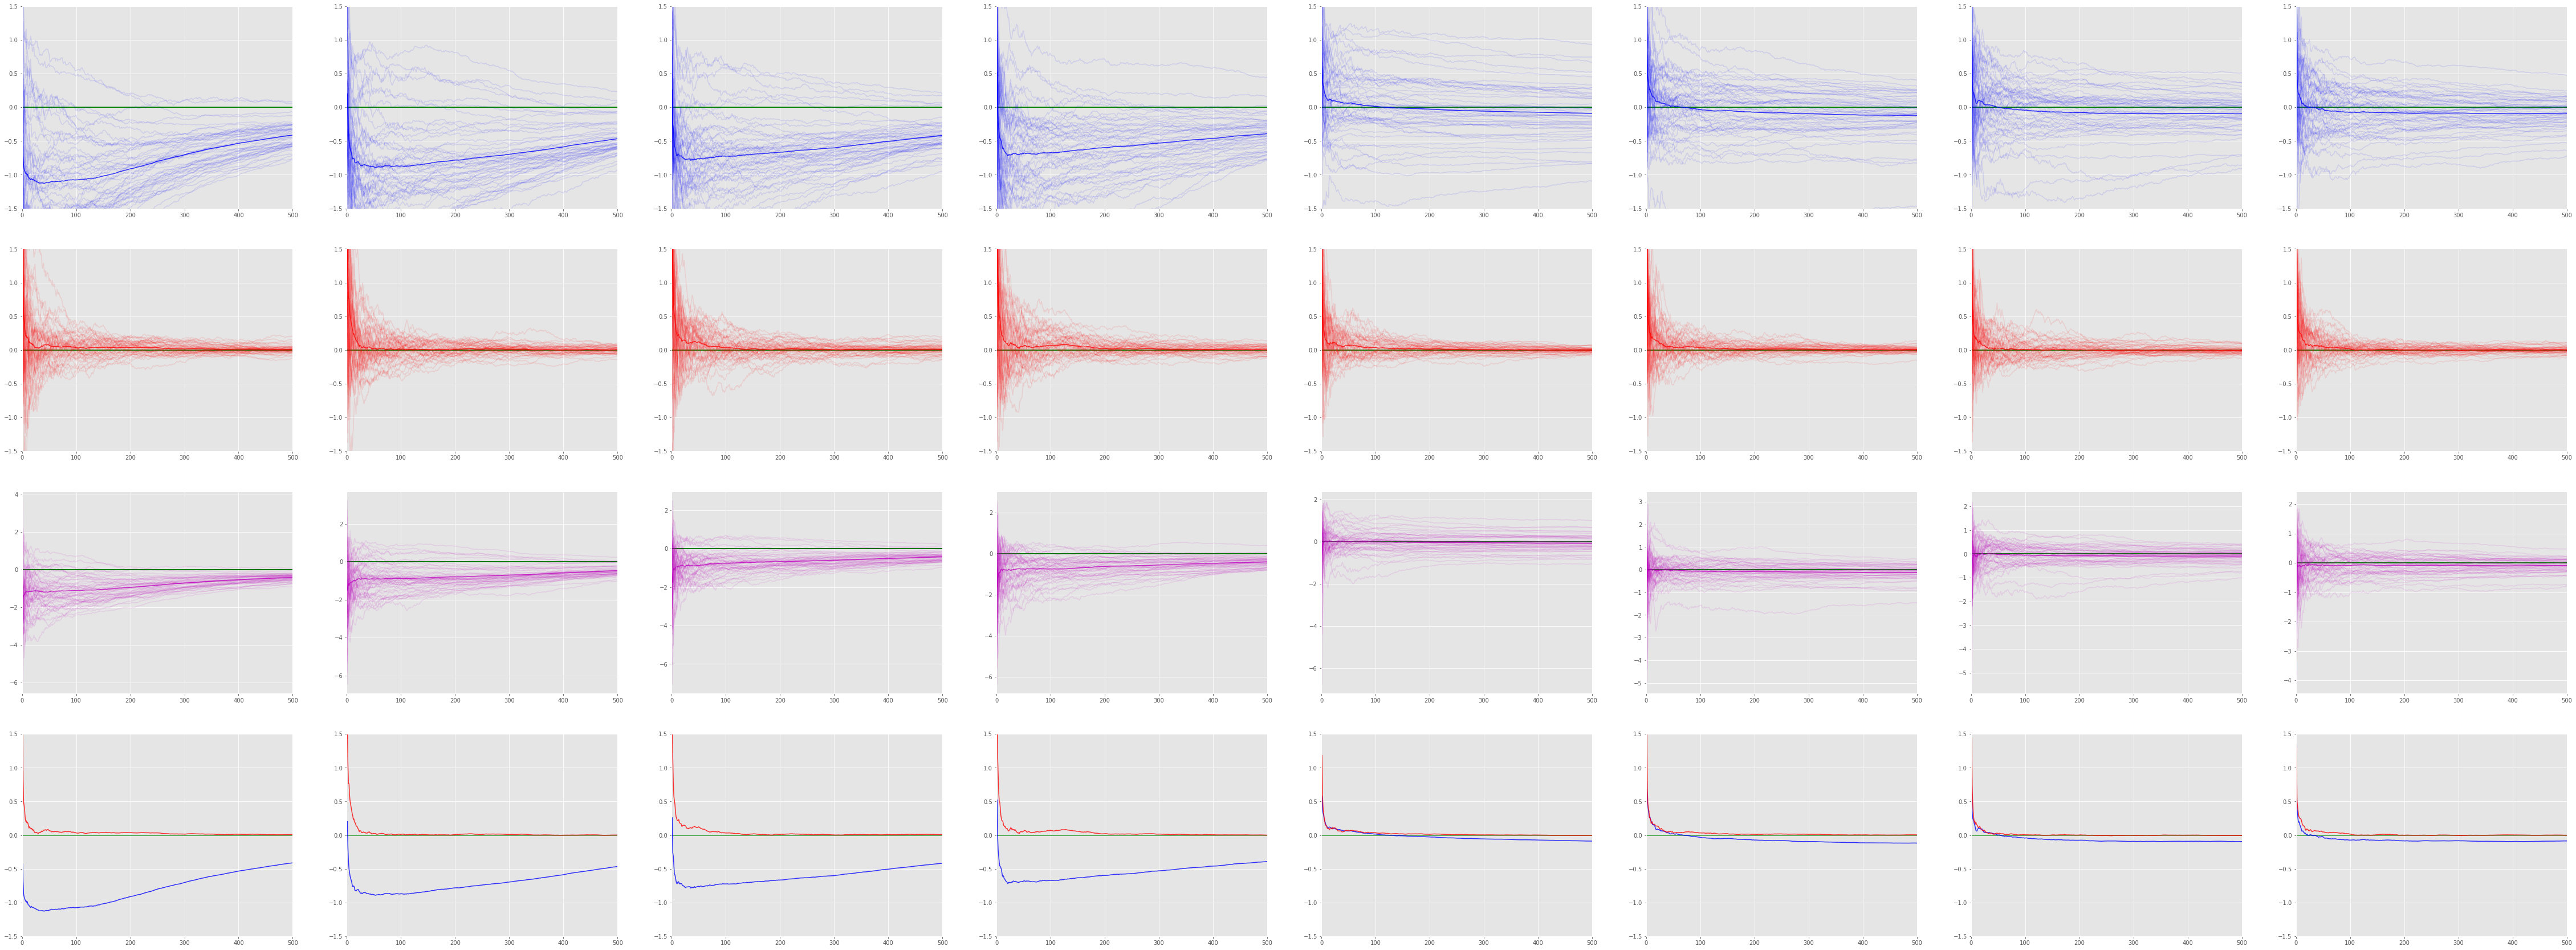

In [125]:
axs2 = plot_results(resultsa + resultsb,1000,(0,500),(-1.5,1.5))

In [33]:
# this data has only categorical variables so we can see that effect
data3 = pd.read_csv('data/flare.data2.csv',header=None, delimiter = ' ')

In [36]:
data3.head(3)

0  1  2   3   4   5   6   7   8   9   10  11  12
0  H  A  X   1   3   1   1   1   1   1   0   0   0
1  D  R  O   1   3   1   1   2   1   1   0   0   0
2  C  S  O   1   3   1   1   2   1   1   0   0   0

In [37]:
X3 = pd.get_dummies(data3,columns=[0,1,2,3,4,5,6,7,8,9]).drop([10,11,12], axis = 1).values
y3 = data3[10].values

In [38]:
parameters = {
    'n_estimators':[1000],
    'max_features':['sqrt','log2',None], 'max_depth':[2,3,4,5],
    'min_samples_split':[.1,.5],'min_samples_leaf':[1,2,5],
}

rfr = RandomForestRegressor()
grid_search3 = GridSearchCV(rfr, param_grid=parameters, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1, cv = 10, verbose = 1)
grid_search3.fit(X3,y3)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.3min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000], 'max_features': ['sqrt', 'log2', None], 'max_depth': [2, 3, 4, 5], 'min_samples_split': [0.1, 0.5], 'min_samples_leaf': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [86]:
params3 = grid_search3.best_params_
params3

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 0.1,
 'n_estimators': 1000}

In [112]:
changesa = [('sqrt',2),('sqrt',3),('sqrt',4),('sqrt',5)]
resultsa = []
titlesa = []
for c in changesa:
    params3['max_features'], params3['max_depth'] = c[0],c[1]
    resultsa.append(run_experiment(X3,y3,5,10,params2))
    titlesa.append('max_features: {}, max_depth: {}'.format(c[0],c[1]))
    
changesb = [(None,2),(None,3),(None,4),(None,5)]
resultsb = []
titlesb = []
for c in changesb:
    params3['max_features'], params3['max_depth'] = c[0],c[1]
    resultsb.append(run_experiment(X3,y3,5,10,params2))
    titlesb.append('max_features: {}, max_depth: {}'.format(c[0],c[1]))



10/50 done in 15.46390438079834 seconds
10/50 done in 15.604697942733765 seconds
10/50 done in 15.612199306488037 seconds
10/50 done in 15.764159917831421 seconds
10/50 done in 15.743584632873535 seconds
10/50 done in 15.645771026611328 seconds
10/50 done in 15.431690216064453 seconds
10/50 done in 15.429672956466675 seconds


mean total error column 0: 0.7591555037499179
mean total error column 1: 0.7578760776319122
mean total error column 2: 0.7529663204405606
mean total error column 3: 0.762621598683423


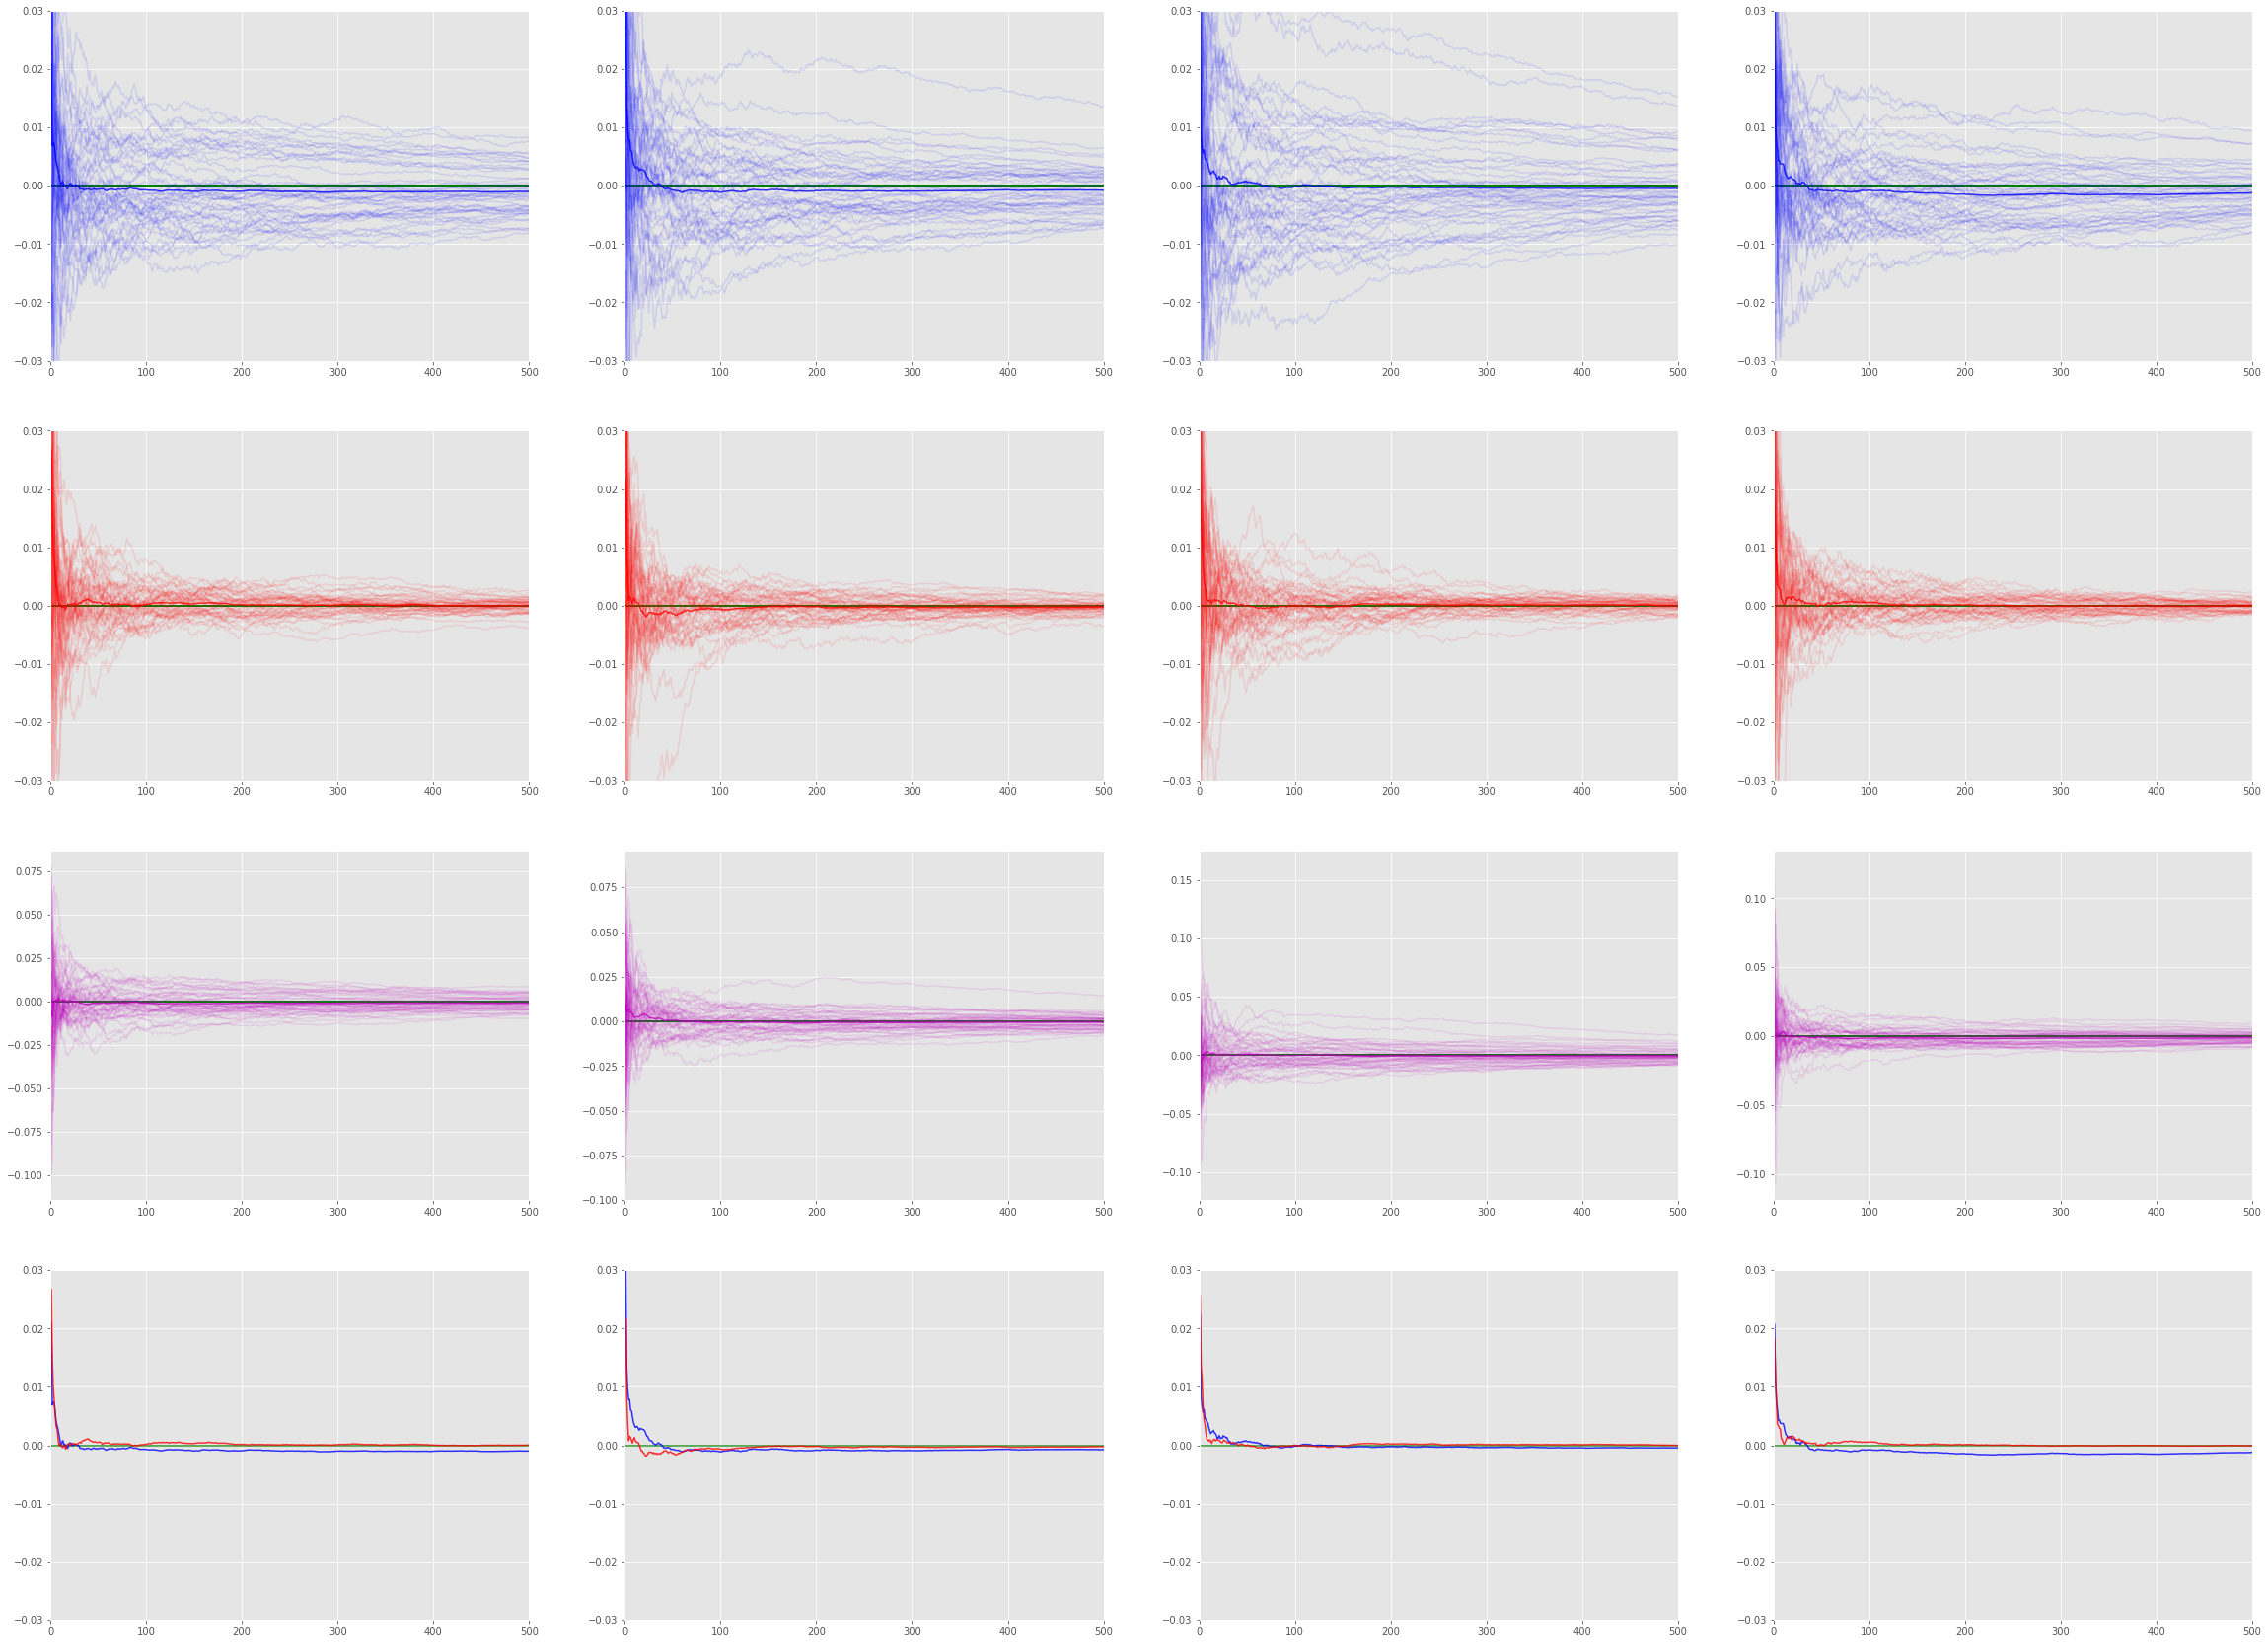

In [113]:
axs3 = plot_results(results3,1000,(0,500),(-.03,.03))

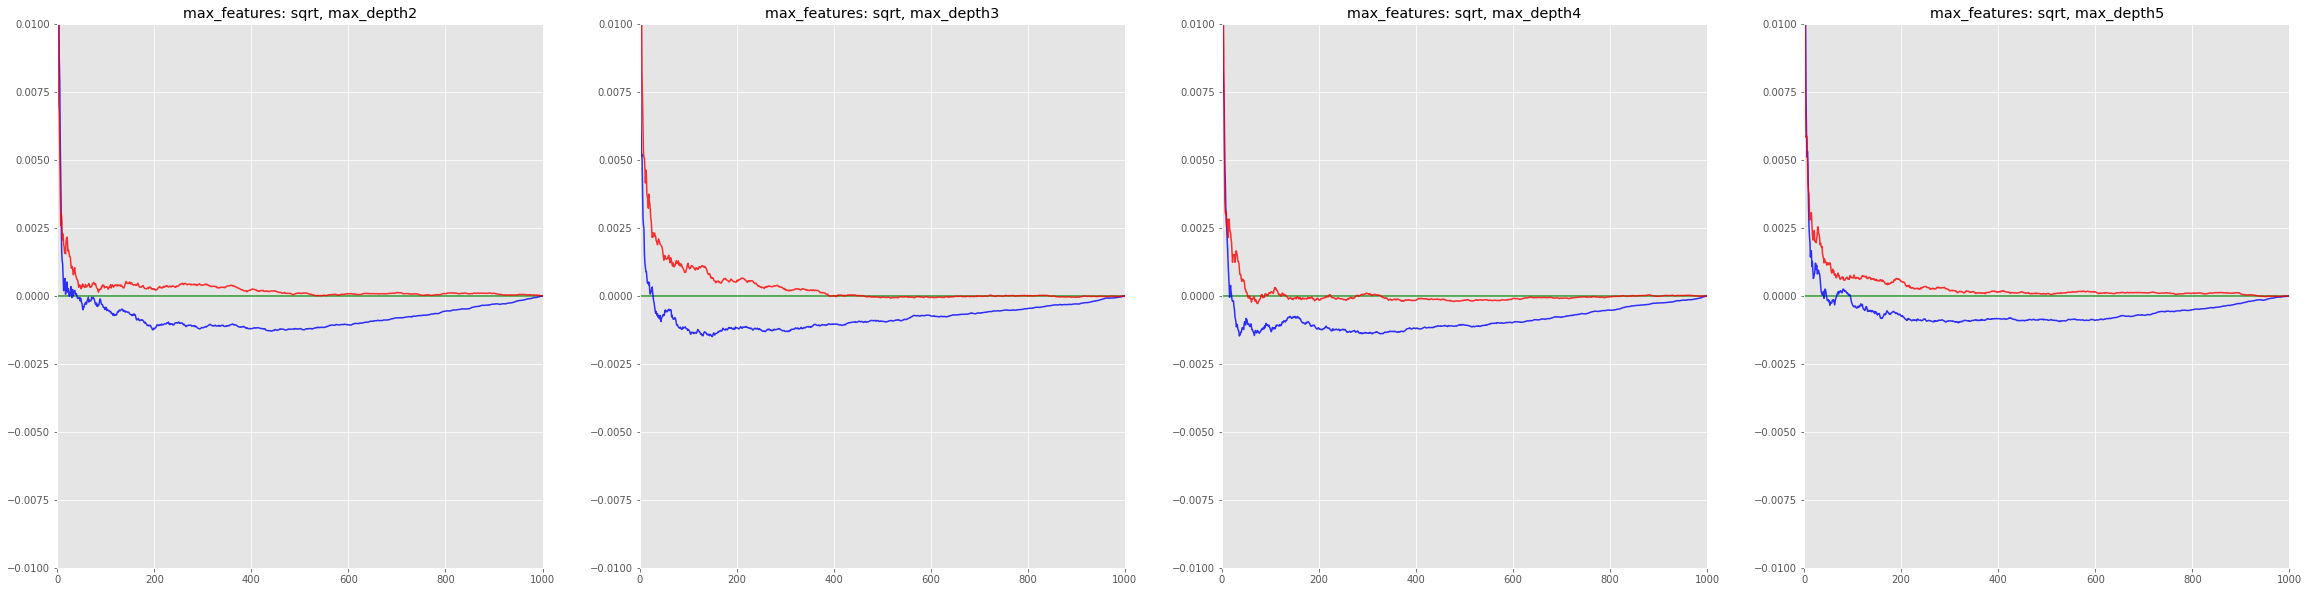

In [114]:
a = plot_average_results(resultsa,1000,(0,1000),(-.01,.01),titlesa)

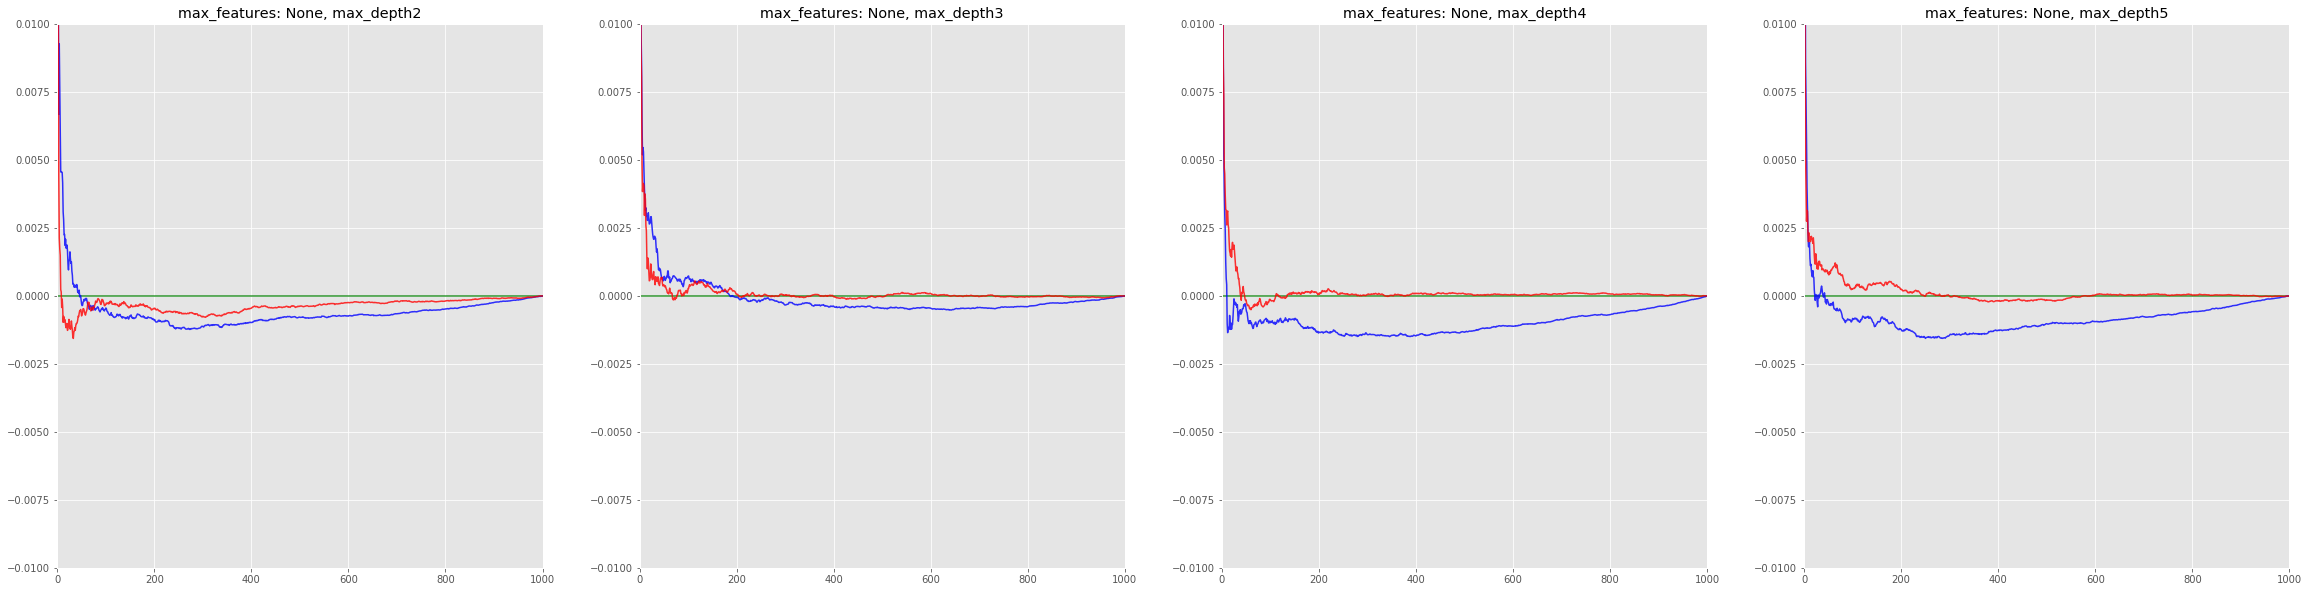

In [115]:
b =  plot_average_results(resultsb,1000,(0,1000),(-.01,.01),titlesb)

In [145]:
data4 = pd.read_csv("data/student-mat.csv",delimiter = ";")

In [151]:
X4 = pd.get_dummies(data4,columns = ['school','sex','address','famsize','Pstatus','Medu',
                    'Fedu','Mjob','Fjob','reason','guardian','traveltime',
                    'studytime','failures','schoolsup','famsup','paid','activities',
                    'activities','nursery','higher','internet','romantic']).drop(['G1','G2','G3'],axis = 1).values
y4 = data4['G3'].values

In [ ]:
parameters = {
    'n_estimators':[1000],
    'max_features':['sqrt','log2',None], 'max_depth':[2,3,4,5],
    'min_samples_split':[.1,.5],'min_samples_leaf':[1,2,5],
}

rfr = RandomForestRegressor()
grid_search4 = GridSearchCV(rfr, param_grid=parameters, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1, cv = 10, verbose = 1)
grid_search4.fit(X4,y4)

In [ ]:
params = grid_search4.best_params_
params

In [244]:
results4 = run_experiment(X4,y4,10,10,params)

10/100 done in 8.430346488952637 seconds
60/100 done in 48.492730379104614 seconds
10/100 done in 7.842536449432373 seconds
60/100 done in 47.473854541778564 seconds
10/100 done in 7.970993518829346 seconds
60/100 done in 48.33489680290222 seconds


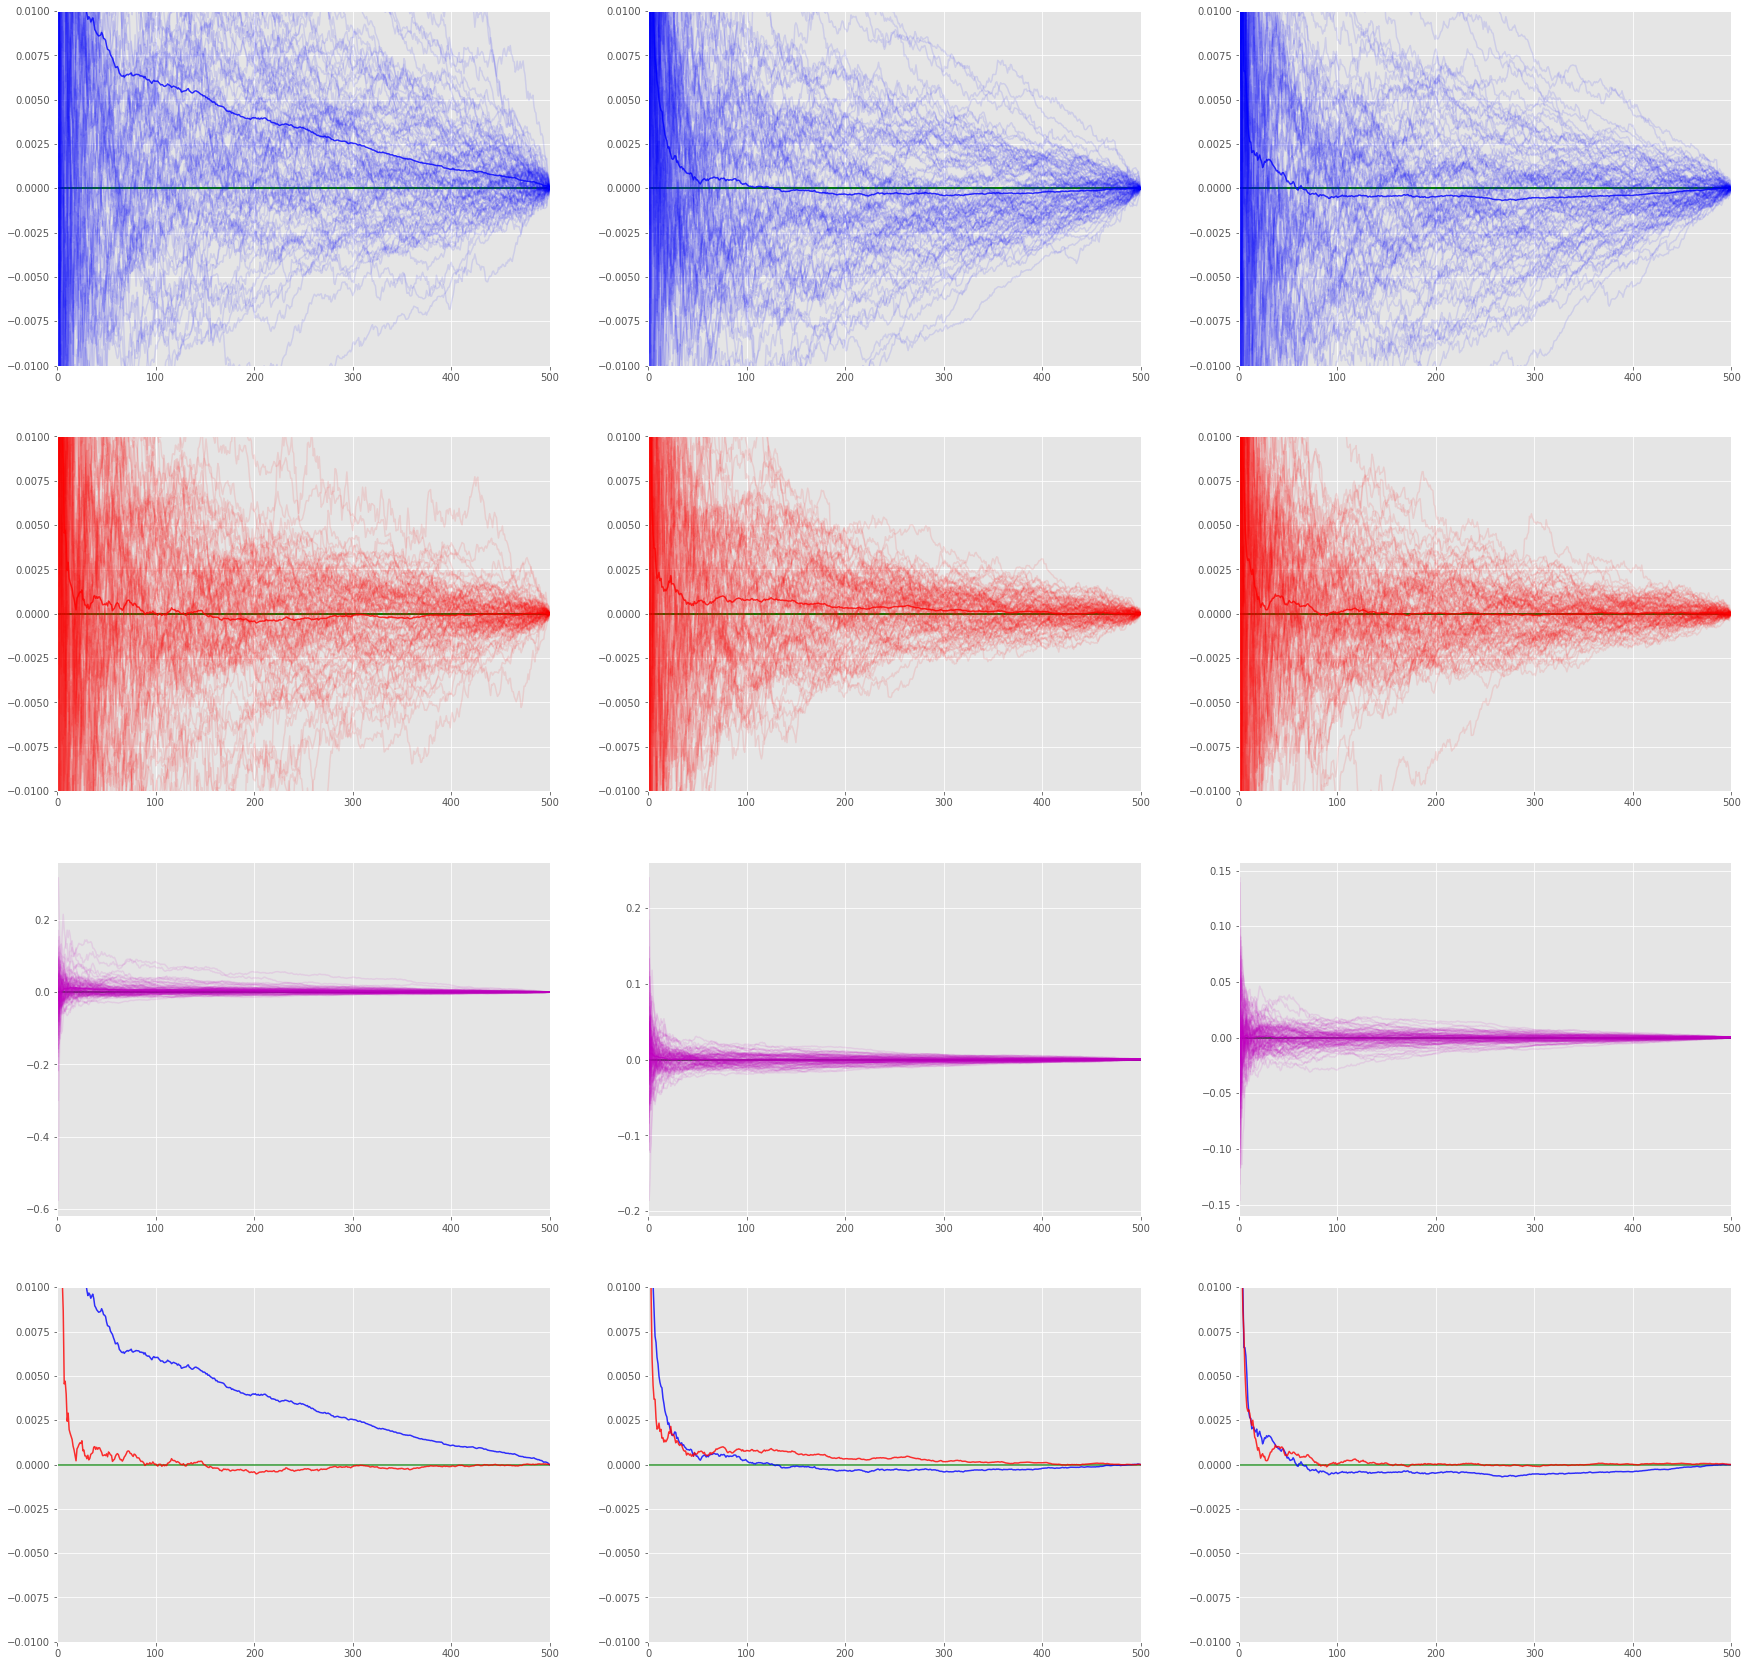

In [247]:
plot_results(results3,500,(0,500),(-.01,.01))

In [34]:
min_ordereds, min_randoms, compared_ordered, compared_random = [],[],[],[]
for total, scores, random_scores in results:
    min_scores = np.argmin(scores)
    min_ordereds.append(min_scores)
    compared = total - min(scores)
    compared_ordered.append(compared)
    min_random = np.argmin(random_scores)
    min_randoms.append(min_random)
    compared= total - min(random_scores)
    compared_random.append(compared)